# Importations

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime, timedelta

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import Binarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
#from aif360.algorithms.inprocessing import AdversarialDebiasing
import tensorflow as tf

pip install 'aif360[inFairness]'


# 1 - Classification

### 1.1 Load and Preprocess Data

In [2]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]
data = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)

# Drop rows with missing values
data.dropna(inplace=True)

# Need to copy the data as we don't want a binarized part for testing the privacy
data_copy = data.copy()

# Binarize the 'age' attribute
binarizer = Binarizer(threshold=30)
data['age'] = binarizer.fit_transform(data[['age']])

# Convert categorical variables to dummy variables
data = pd.get_dummies(data, drop_first=True)

data

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_>50K
0,1,77516,13,2174,0,40,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,1,83311,13,0,0,13,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,1,215646,9,0,0,40,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,1,234721,7,0,0,40,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
4,0,338409,13,0,0,40,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,257302,12,0,0,38,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
32557,1,154374,9,0,0,40,False,False,False,True,...,False,False,False,False,False,False,True,False,False,True
32558,1,151910,9,0,0,40,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
32559,0,201490,9,0,0,20,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False


### 1.2 Train a logistic regression classifier and measure its performance

In [3]:
# Split the data into features and target variable
X = data.drop('income_>50K', axis=1)
y = data['income_>50K']

# Split the data into train, validation, and test sets (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train a logistic regression classifier
classifier = LogisticRegression(max_iter=2000)
classifier.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test_scaled)

# Measure performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

performance_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

print("Performance Metrics:", performance_metrics)


Performance Metrics: {'Accuracy': 0.8552712384851586, 'Precision': 0.7271750805585392, 'Recall': 0.5991150442477876, 'F1 Score': 0.6569626394953906}


# 2 - Fairness


**2.2 Fairness Metrics**

In [4]:
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio

# Define sensitive features: 'age' and 'sex_Male'
age_sensitive = X_test['age']
sex_sensitive = X_test['sex_Male']

# Compute fairness metrics for the original classifier
dpd_age = demographic_parity_difference(y_test, y_pred, sensitive_features=age_sensitive)
dpr_age = demographic_parity_ratio(y_test, y_pred, sensitive_features=age_sensitive)

dpd_sex = demographic_parity_difference(y_test, y_pred, sensitive_features=sex_sensitive)
dpr_sex = demographic_parity_ratio(y_test, y_pred, sensitive_features=sex_sensitive)

print("Fairness Metrics (Original Classifier):")
print(f"Age - Demographic Parity Difference: {dpd_age}, Demographic Parity Ratio: {dpr_age}")
print(f"Sex - Demographic Parity Difference: {dpd_sex}, Demographic Parity Ratio: {dpr_sex}")


Fairness Metrics (Original Classifier):
Age - Demographic Parity Difference: 0.2461163789376603, Demographic Parity Ratio: 0.08738725259693071
Sex - Demographic Parity Difference: 0.1725282306338493, Demographic Parity Ratio: 0.3045489515167733


**2.3 Apply a Fairness Mitigation Technique**

In [5]:
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression

# Convert data into BinaryLabelDataset format
binary_data = BinaryLabelDataset(
    df=pd.concat([X_train, y_train], axis=1),  # Combine features and target
    label_names=['income_>50K'],               # Target column
    protected_attribute_names=['age', 'sex_Male']  # Sensitive attributes
)

# Apply reweighting to the data
rw = Reweighing(unprivileged_groups=[{'age': 0}], privileged_groups=[{'age': 1}])  # Reweigh based on age
rw.fit(binary_data)  # Fit the reweighing model
reweighted_data = rw.transform(binary_data)  # Apply reweighting

# Train the classifier using the reweighted data
classifier_reweighted = LogisticRegression(max_iter=2000)
classifier_reweighted.fit(X_train_scaled, y_train, sample_weight=reweighted_data.instance_weights)

# Predict and measure performance on the reweighted classifier
y_pred_reweighted = classifier_reweighted.predict(X_test_scaled)

# Performance metrics for reweighted classifier
accuracy_reweighted = accuracy_score(y_test, y_pred_reweighted)
precision_reweighted = precision_score(y_test, y_pred_reweighted)
recall_reweighted = recall_score(y_test, y_pred_reweighted)
f1_reweighted = f1_score(y_test, y_pred_reweighted)

print("\nReweighted Classifier Performance Metrics:")
print(f"Accuracy: {accuracy_reweighted}")
print(f"Precision: {precision_reweighted}")
print(f"Recall: {recall_reweighted}")
print(f"F1 Score: {f1_reweighted}")


Reweighted Classifier Performance Metrics:
Accuracy: 0.8380757420675538
Precision: 0.6968641114982579
Recall: 0.5309734513274337
F1 Score: 0.6027122049221497


**2.4 Report Fairness Metrics on the Classifier and the Fair Classifier**

In [6]:
dpd_reweighted_age = demographic_parity_difference(y_test, y_pred_reweighted, sensitive_features=age_sensitive)
dpr_reweighted_age = demographic_parity_ratio(y_test, y_pred_reweighted, sensitive_features=age_sensitive)

dpd_reweighted_sex = demographic_parity_difference(y_test, y_pred_reweighted, sensitive_features=sex_sensitive)
dpr_reweighted_sex = demographic_parity_ratio(y_test, y_pred_reweighted, sensitive_features=sex_sensitive)

In [7]:
import pandas as pd

# Fairness metrics for the original classifier
metrics_original = {
    'Metric': ['Demographic Parity Difference (Age)', 'Demographic Parity Ratio (Age)',
               'Demographic Parity Difference (Sex)', 'Demographic Parity Ratio (Sex)'],
    'Original Classifier': [dpd_age, dpr_age, dpd_sex, dpr_sex]
}

# Performance metrics for the original classifier
metrics_original_performance = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Original Classifier': [accuracy, precision, recall, f1]
}

# Fairness metrics for the reweighted classifier
metrics_reweighted = {
    'Metric': ['Demographic Parity Difference (Age)', 'Demographic Parity Ratio (Age)',
               'Demographic Parity Difference (Sex)', 'Demographic Parity Ratio (Sex)'],
    'Reweighted Classifier': [dpd_reweighted_age, dpr_reweighted_age, dpd_reweighted_sex, dpr_reweighted_sex]
}

# Performance metrics for the reweighted classifier
metrics_reweighted_performance = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Reweighted Classifier': [accuracy_reweighted, precision_reweighted, recall_reweighted, f1_reweighted]
}

# Convert dictionaries to dataframes
df_original = pd.DataFrame(metrics_original)
df_original_performance = pd.DataFrame(metrics_original_performance)
df_reweighted = pd.DataFrame(metrics_reweighted)
df_reweighted_performance = pd.DataFrame(metrics_reweighted_performance)

# Display fairness metrics and performance metrics in tables
print("Fairness Metrics Comparison (Original vs Reweighted Classifier):")
print(pd.concat([df_original.set_index('Metric'), df_reweighted.set_index('Metric')], axis=1))

print("\nPerformance Metrics Comparison (Original vs Reweighted Classifier):")
print(pd.concat([df_original_performance.set_index('Metric'), df_reweighted_performance.set_index('Metric')], axis=1))


Fairness Metrics Comparison (Original vs Reweighted Classifier):
                                     Original Classifier  \
Metric                                                     
Demographic Parity Difference (Age)             0.246116   
Demographic Parity Ratio (Age)                  0.087387   
Demographic Parity Difference (Sex)             0.172528   
Demographic Parity Ratio (Sex)                  0.304549   

                                     Reweighted Classifier  
Metric                                                      
Demographic Parity Difference (Age)               0.100166  
Demographic Parity Ratio (Age)                    0.519463  
Demographic Parity Difference (Sex)               0.140902  
Demographic Parity Ratio (Sex)                    0.368751  

Performance Metrics Comparison (Original vs Reweighted Classifier):
           Original Classifier  Reweighted Classifier
Metric                                               
Accuracy              0.855271 

# 3 - Privacy


### 3.1 First cross tabulation

In [8]:
# Cross-tabulation on age and sex
sensitive_crosstab = pd.crosstab(data_copy['age'], data_copy['sex'])

print("the distribution is the following: \n", sensitive_crosstab)

the distribution is the following: 
 sex  Female  Male
age              
17      186   209
18      268   282
19      356   356
20      363   390
21      329   391
..      ...   ...
85        1     2
86        1     0
87        0     1
88        1     2
90       14    29

[73 rows x 2 columns]


### 3.2 Local differential privacy

In [9]:
# making a private dataset
private_data = data_copy.copy()

#We can change the values of the epsilon to make tests on them here, the current ones are the ones
#that seemed the more coherent after testing multiple ones
epsilon_age = 5
epsilon_sex = 0.2 #so 20% of the sex values are changed

#Apply Laplace noise and round it(for age)
def laplace_noise(value, epsilon):
    return round(value + np.random.laplace(0, 1 / epsilon))

#Apply randomized response (for sex)
def randomized_response(value, epsilon):
    if np.random.rand() < epsilon_sex: #this way, the valu of epsilo_sex is the proportion of changed sex
        return 'Male' if (value == 'Female') else 'Female'
    return value

#remark: we can't take a epsilon too small for sex, else we risk blurring information on sex inequalities

#Apply local differential privacy to age and sex on dataPrivate
private_data['age'] = data_copy['age'].apply(lambda x: laplace_noise(x, epsilon_age))
private_data['sex'] = data_copy['sex'].apply(lambda x: randomized_response(x, epsilon_sex))

# Concatenate the 'age' and 'sex' columns from both original (dataCopy) and private (dataPrivate) data
comparison_df = pd.concat([data_copy[['age', 'sex']], private_data[['age', 'sex']]], axis=1)
comparison_df.columns = ['Original Age', 'Original Sex', 'Private Age', 'Private Sex']
comparison_df = comparison_df[['Original Age', 'Private Age', 'Original Sex', 'Private Sex']]

# Show the comparison to see how the private dataset differs from the original one
print(comparison_df)

       Original Age  Private Age Original Sex Private Sex
0                39           39         Male        Male
1                50           50         Male        Male
2                38           38         Male        Male
3                53           53         Male        Male
4                28           28       Female      Female
...             ...          ...          ...         ...
32556            27           27       Female      Female
32557            40           40         Male        Male
32558            58           57       Female      Female
32559            22           22         Male      Female
32560            52           52       Female        Male

[32561 rows x 4 columns]


### 3.3 Cross tabulation on the private dataset

In [10]:
#Cross-tabulation for the private data
private_crosstab = pd.crosstab(private_data['age'], private_data['sex'])

print("the distribution on the private data is the following:\n", private_crosstab)

# Align both crosstabs, necessary, else it returns an empty dataset
sensitive_crosstab, private_crosstab = sensitive_crosstab.align(private_crosstab, join='outer', axis=0, fill_value=0)

#Calculate the estimation errors
#this shows the differences in distribution between the private and original dataset
comparison_crosstab = sensitive_crosstab.subtract(private_crosstab, fill_value=0)
print("Estimation error:\n", comparison_crosstab)

print("note: negative values mean there are more in the private dataset than in the original one")

the distribution on the private data is the following:
 sex  Female  Male
age              
16        6    10
17      201   193
18      265   275
19      349   362
20      356   389
..      ...   ...
87        0     1
88        2     1
89        2     0
90       14    26
91        1     0

[76 rows x 2 columns]
Estimation error:
 sex  Female  Male
age              
16       -6   -10
17      -15    16
18        3     7
19        7    -6
20        7     1
..      ...   ...
87        0     0
88       -1     1
89       -2     0
90        0     3
91       -1     0

[76 rows x 2 columns]
note: negative values mean there are more in the private dataset than in the original one


### 3.4 Data splitting and classification

In [11]:
# we binarize the ages again
private_data['age'] = binarizer.fit_transform(data[['age']])

# Convert categorical variables to dummy variables
private_data = pd.get_dummies(data, drop_first=True)

#now we make a process similar to the one from (1):

# Split the data into features and target variable
X_p = private_data.drop('income_>50K', axis=1)
Y_p = private_data['income_>50K']

# Split the data into train, validation, and test sets (70% train, 15% validation, 15% test)
X_train_p, X_temp_p, Y_train_p, Y_temp_p = train_test_split(X_p, Y_p, test_size=0.3, random_state=42)
X_val_p, X_test_p, Y_val_p, Y_test_p = train_test_split(X_temp_p, Y_temp_p, test_size=0.5, random_state=42)

# Scale the data
#scaler was already defined in (1)
X_train_scaled_p = scaler.fit_transform(X_train_p)
X_val_scaled_p = scaler.transform(X_val_p)
X_test_scaled_p = scaler.transform(X_test_p)

# Train a logistic regression classifier
private_classifier = LogisticRegression(max_iter=2000)
private_classifier.fit(X_train_scaled_p, Y_train_p)


# Predict on the test set
Y_pred_p = private_classifier.predict(X_test_scaled_p)

### 3.5 Performances measuring

In [12]:
# Measure performance on the private classifier
private_accuracy = accuracy_score(Y_test_p, Y_pred_p)
private_precision = precision_score(Y_test_p, Y_pred_p)
private_recall = recall_score(Y_test_p, Y_pred_p)
private_f1 = f1_score(Y_test_p, Y_pred_p)

private_performance_metrics = {
    'Accuracy': private_accuracy,
    'Precision': private_precision,
    'Recall': private_recall,
    'F1 Score': private_f1
}

print("Performance Metrics of the original dataset:", performance_metrics)
print("Performance Metrics of the private dataset: ", private_performance_metrics)

Performance Metrics of the original dataset: {'Accuracy': 0.8552712384851586, 'Precision': 0.7271750805585392, 'Recall': 0.5991150442477876, 'F1 Score': 0.6569626394953906}
Performance Metrics of the private dataset:  {'Accuracy': 0.8552712384851586, 'Precision': 0.7271750805585392, 'Recall': 0.5991150442477876, 'F1 Score': 0.6569626394953906}


# 4 - Privacy and Fairness


In [13]:
# Convert the private data into BinaryLabelDataset format
binary_private_data = BinaryLabelDataset(
    df=pd.concat([X_train_p, Y_train_p], axis=1),
    label_names=['income_>50K'],
    protected_attribute_names=['age']
)

# Apply Reweighing to the private data
rw_private = Reweighing(unprivileged_groups=[{'age': 0}], privileged_groups=[{'age': 1}])
rw_private.fit(binary_private_data)  # Fit the Reweighing algorithm
reweighted_private_data = rw_private.transform(binary_private_data)  # Apply weights

# Train the logistic regression classifier with reweighted data
private_fair_classifier = LogisticRegression(max_iter=2000)
private_fair_classifier.fit(X_train_scaled_p, Y_train_p, sample_weight=reweighted_private_data.instance_weights)

# Predict on the test set
Y_pred_private_fair = private_fair_classifier.predict(X_test_scaled_p)

# Performance metrics for Private+Fair Classifier
accuracy_private_fair = accuracy_score(Y_test_p, Y_pred_private_fair)
precision_private_fair = precision_score(Y_test_p, Y_pred_private_fair)
recall_private_fair = recall_score(Y_test_p, Y_pred_private_fair)
f1_private_fair = f1_score(Y_test_p, Y_pred_private_fair)

# Display metrics
print("Private+Fair Classifier Performance Metrics:")
print(f"Accuracy: {accuracy_private_fair}")
print(f"Precision: {precision_private_fair}")
print(f"Recall: {recall_private_fair}")
print(f"F1 Score: {f1_private_fair}")

Private+Fair Classifier Performance Metrics:
Accuracy: 0.8380757420675538
Precision: 0.6968641114982579
Recall: 0.5309734513274337
F1 Score: 0.6027122049221497


In [14]:
age_sensitive_private = X_test_p['age']  
sex_sensitive_private = X_test_p['sex_Male'] 

# Fairness metrics for the Private+Fair Classifier
dpd_private_fair_age = demographic_parity_difference(Y_test_p, Y_pred_private_fair, sensitive_features=age_sensitive_private)
dpr_private_fair_age = demographic_parity_ratio(Y_test_p, Y_pred_private_fair, sensitive_features=age_sensitive_private)

dpd_private_fair_sex = demographic_parity_difference(Y_test_p, Y_pred_private_fair, sensitive_features=sex_sensitive_private)
dpr_private_fair_sex = demographic_parity_ratio(Y_test_p, Y_pred_private_fair, sensitive_features=sex_sensitive_private)

print("\nPrivate+Fair Classifier Fairness Metrics:")
print(f"Age - Demographic Parity Difference: {dpd_private_fair_age}, Demographic Parity Ratio: {dpr_private_fair_age}")
print(f"Sex - Demographic Parity Difference: {dpd_private_fair_sex}, Demographic Parity Ratio: {dpr_private_fair_sex}")



Private+Fair Classifier Fairness Metrics:
Age - Demographic Parity Difference: 0.10016620072820898, Demographic Parity Ratio: 0.5194631614847862
Sex - Demographic Parity Difference: 0.14090196205639866, Demographic Parity Ratio: 0.36875145747222776


In [15]:
# Fairness metrics for private+fair classifier
metrics_private_fair = {
    'Metric': ['Demographic Parity Difference (Age)', 'Demographic Parity Ratio (Age)',
               'Demographic Parity Difference (Sex)', 'Demographic Parity Ratio (Sex)'],
    'Private+Fair Classifier': [dpd_private_fair_age, dpr_private_fair_age, dpd_private_fair_sex, dpr_private_fair_sex]
}

# Performance metrics for private+fair classifier
metrics_private_fair_performance = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Private+Fair Classifier': [accuracy_private_fair, precision_private_fair, recall_private_fair, f1_private_fair]
}

# Convert to DataFrames
df_private_fair = pd.DataFrame(metrics_private_fair)
df_private_fair_performance = pd.DataFrame(metrics_private_fair_performance)

# Display comparison tables
print("\nFairness Metrics Comparison (Original vs Reweighted vs Private+Fair Classifier):")
print(pd.concat([df_original.set_index('Metric'), 
                 df_reweighted.set_index('Metric'), 
                 df_private_fair.set_index('Metric')], axis=1))

print("\nPerformance Metrics Comparison (Original vs Reweighted vs Private+Fair Classifier):")
print(pd.concat([df_original_performance.set_index('Metric'), 
                 df_reweighted_performance.set_index('Metric'), 
                 df_private_fair_performance.set_index('Metric')], axis=1))



Fairness Metrics Comparison (Original vs Reweighted vs Private+Fair Classifier):
                                     Original Classifier  \
Metric                                                     
Demographic Parity Difference (Age)             0.246116   
Demographic Parity Ratio (Age)                  0.087387   
Demographic Parity Difference (Sex)             0.172528   
Demographic Parity Ratio (Sex)                  0.304549   

                                     Reweighted Classifier  \
Metric                                                       
Demographic Parity Difference (Age)               0.100166   
Demographic Parity Ratio (Age)                    0.519463   
Demographic Parity Difference (Sex)               0.140902   
Demographic Parity Ratio (Sex)                    0.368751   

                                     Private+Fair Classifier  
Metric                                                        
Demographic Parity Difference (Age)                 0.1001

### Conclusion
#### Fairness Achieved with Reweighting and Privacy
 - Both the Fair Classifier and Private+Fair Classifier significantly
   reduce demographic disparities compared to the Original Classifier,
   achieving much better fairness with respect to Age and Sex.
  - Privacy constraints in the Private+Fair Classifier do not compromise
   fairness or performance, achieving parity with the Fair Classifier.

# 5 - Explainability


In [16]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("dependencies")

from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import TabularExplainer
import xgboost as xgboost
from itertools import cycle, islice

Test: accuracy_private_fair=0.8381
Test: TP=600, TN=3494, FP=261, FN=530


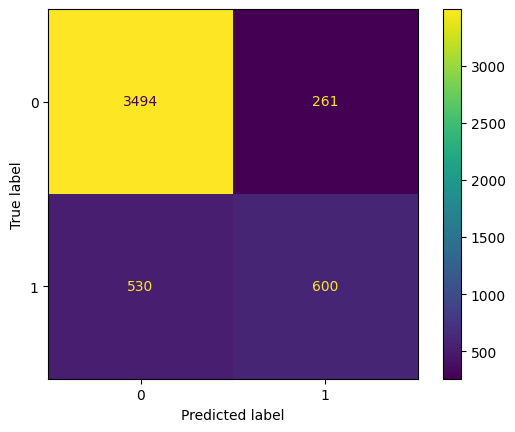

In [17]:
print(f'Test: {accuracy_private_fair=:.4f}')
#confusion_matrix for the private classifier
cm = confusion_matrix(Y_test_p, Y_pred_private_fair)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot();

#### Instances where the model is wrong but highly confident:

In [18]:
# Find instances where the predicted label is different from the actual label
miss_indices = np.where(Y_pred_private_fair != Y_test_p)[0]

# Create the prediction probabilities
proba = private_classifier.predict_proba(X_test_scaled_p)

# Find instances where the model is very confident but wrong
miss_but_confident = []

for idx in miss_indices:
    if max(proba[idx]) > 0.95:
        miss_but_confident.append(idx)
    
print(f"There are {len(miss_but_confident)} instances where the model is very confident but wrong.")

for instance_id in miss_but_confident:
    print(f"\t-> Instance {instance_id} has label '{Y_test_p.values[instance_id]}' and prediction '{Y_pred_private_fair[instance_id]}', with probs {private_classifier.predict_proba(X_test_scaled_p[instance_id:instance_id+1])[0]}")

There are 30 instances where the model is very confident but wrong.
	-> Instance 246 has label 'True' and prediction 'False', with probs [0.97876462 0.02123538]
	-> Instance 367 has label 'True' and prediction 'False', with probs [0.99403692 0.00596308]
	-> Instance 885 has label 'True' and prediction 'False', with probs [0.95024223 0.04975777]
	-> Instance 1423 has label 'True' and prediction 'False', with probs [0.95875103 0.04124897]
	-> Instance 1438 has label 'True' and prediction 'False', with probs [0.97051301 0.02948699]
	-> Instance 1449 has label 'True' and prediction 'False', with probs [0.98787512 0.01212488]
	-> Instance 1552 has label 'True' and prediction 'False', with probs [0.96171127 0.03828873]
	-> Instance 1579 has label 'True' and prediction 'False', with probs [0.98093825 0.01906175]
	-> Instance 1670 has label 'True' and prediction 'False', with probs [0.99538502 0.00461498]
	-> Instance 1774 has label 'False' and prediction 'True', with probs [0.00542594 0.99457

#### Explanation:

...

#### Are the noisy values for the sensitive values of Age and Sex attributes responsible for the model being confident and wrong?

...

#  6 - Explainability and LLMs

# 7 - Free Exploration

In [19]:
print("Last execution of this notebook:",datetime.utcnow()+timedelta(hours=1))

Last execution of this notebook: 2024-12-07 23:29:49.480776
